# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Segmentation Models Pytorch, torchmetrics installation</span> <a id=1.1.1></a> <br>

In [1]:
!pip install -qqq segmentation-models-pytorch
!pip install -qqq torchmetrics

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Import Libraries</span> <a id=1.1.1></a> <br>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

from pprint import pprint

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

In [3]:
img_data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv') # mask data?
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [4]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [5]:
img_data.shape

(110, 18)

In [6]:
data_path = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [7]:
filenames = data_path[::2]
masks = data_path[1::2]

In [8]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print(df.shape)
df

(7858, 2)


,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
7853,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [9]:
original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [10]:
original_img, mask_img

(                 patient_id                                           img_path
 0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 5     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ...                     ...                                                ...
 7849  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7850  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [3929 rows x 2 columns],
            

In [11]:
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_25.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_25_mask.tif


In [12]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [13]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [14]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [15]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))

print(mri_df.shape)
mri_df

(3929, 4)


,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [16]:
mri_df.drop(columns=['patient_id'],inplace=True)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">EDA</span> <a id=2></a> <br>

Check Balancing in Data

<AxesSubplot:title={'center':'Count of Tumour vs No Tumour'}>

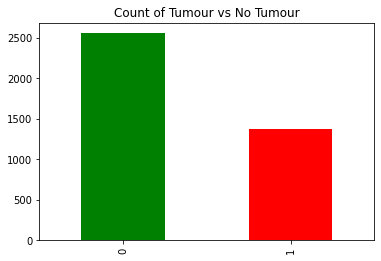

In [17]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [18]:
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Image Visualization</span> <a id=2.1></a> <br>

Visualising the Brain MRI with Tumour

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


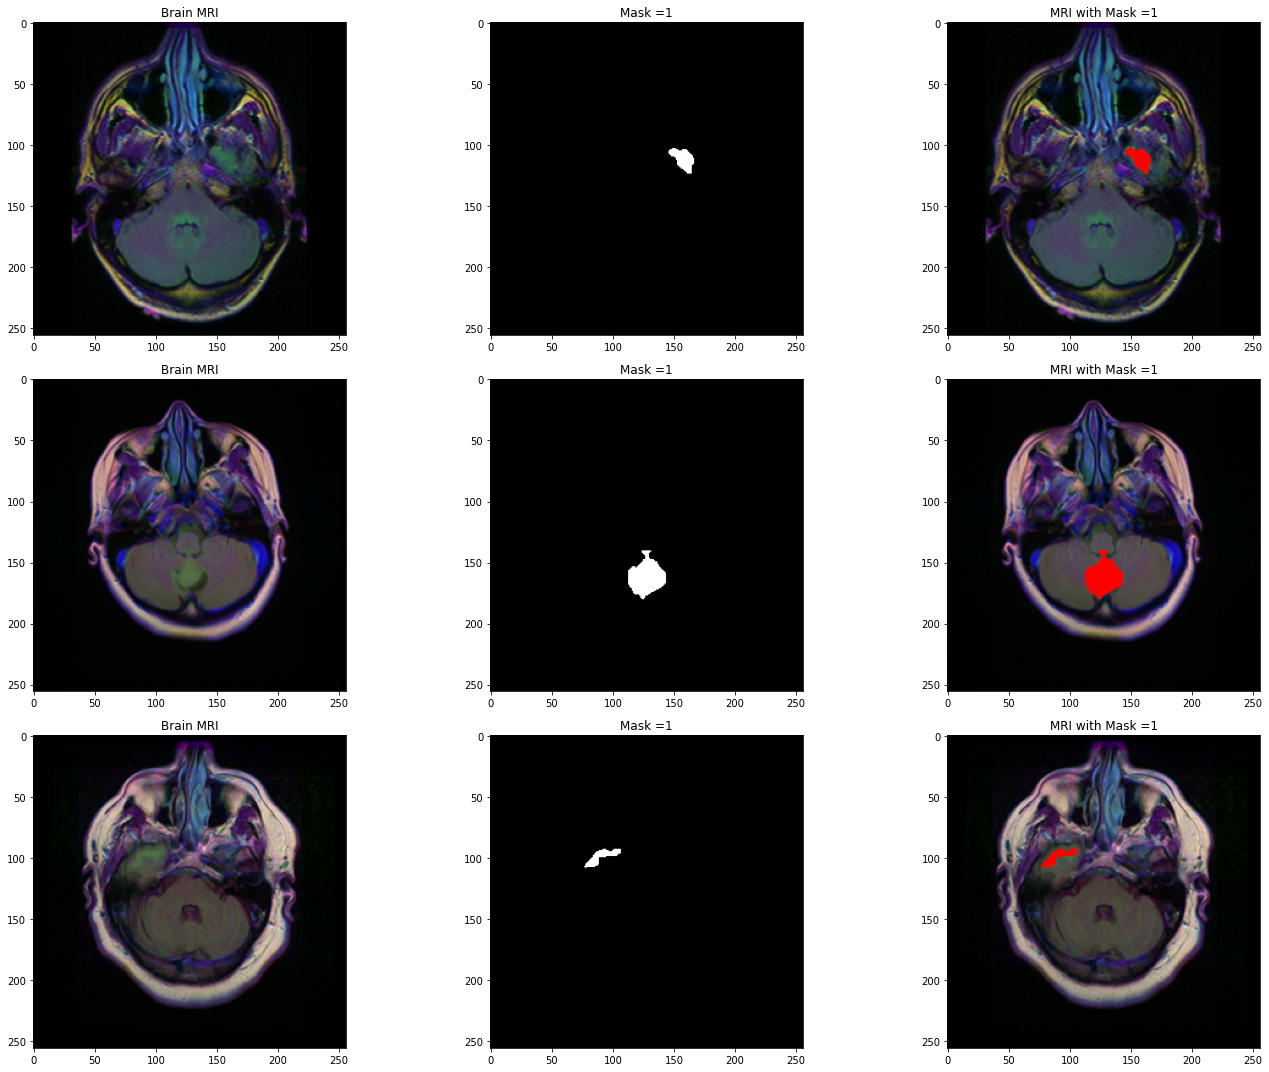

In [19]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        print(img.shape)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">prepare_loaders</span> <a id=3></a> <br>

In [20]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

## <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Dataset</span> <a id=1.1.1></a> <br>

In [21]:
def adjust_data(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    
    return (img, mask)

In [22]:
class MyDataset(Dataset):
    def __init__(self, df= mri_df, 
                 adjust_data = adjust_data, 
                 image_transform=image_transform, mask_transform=mask_transform):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data= adjust_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
#         mask =cv2.imread(mask_path, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#         _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        image, mask = self.adjust_data(image, mask)

        if self.image_transform:
            image = self.image_transform(image).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

## <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Sample</span> <a id=1.1.1></a> <br>

In [23]:
index = 2911
data = MyDataset()[index]
data[0].shape, data[1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

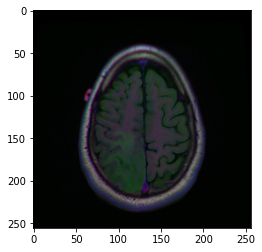

In [24]:
plt.imshow(data[0].permute(1, 2, 0).numpy())

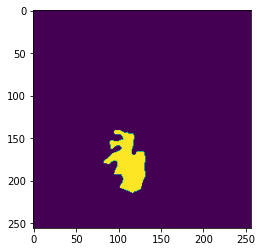

In [25]:
plt.imshow(data[1].permute(1, 2, 0).squeeze(-1).numpy())

In [26]:
np.unique(data[1])

array([0., 1.])

## <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">DataLoader</span> <a id=1.1.1></a> <br>

In [27]:
def prepare_loaders(df= mri_df,
                    train_num= int(mri_df.shape[0] * .6), 
                    valid_num= int(mri_df.shape[0] * .8), 
                    bs = 32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)    
    test  = df[valid_num:].reset_index(drop=True)

    train_ds = MyDataset(df = train)
    valid_ds = MyDataset(df = valid)
    test_ds = MyDataset(df = test)

    train_loader = DataLoader(train_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, num_workers = os.cpu_count(), shuffle = True)
    
    print("DataLoader Completed")
    
    return train_loader, valid_loader, test_loader

In [28]:
train_loader, valid_loader, test_loader = prepare_loaders(df= mri_df,
                                                            train_num= int(mri_df.shape[0] * .65), 
                                                            valid_num= int(mri_df.shape[0] * .85), 
                                                            bs = 32)

DataLoader Completed


In [29]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

# <p style="color:#FF0000;background-color:white;font-size:25px">Build UNet Model</span> <a id=4></a> <br>

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNet Architecture</span> <a id=4.1></a>

<center><img src= "https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt ="UNet" style='width:800px;'></center>

UNet is named after the shape of it's architecture (U - shaped). UNet model is used to solve Image Segmentation problems especially in Medical related problems.

The input layer has 572x572x1 dimension in the above architecture. The 1 column dimension specifies the input is b/w image. If the input dimension was 572x572x3 , the input image is rgb coloured image.
After the input layer,we can divide this UNet architecture into 4 parts
* Encoder Part (Contracting path)
* Upsampling2D
* Decoder part (Expanding Path)
* Skip Connection (Residual connection)


Briefly into the Details of these parts: <br>
**Encoder Part**
The initial half of the U-shaped architecture is the Contracting path(Encoder part). As the name Contracting path denotes, the dimension of the input image keeps reducing as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=64 followed by Maxpool2D layer (reduces size divided by 2). Now again 2 - Conv2D layers (128 filters) and 1 Maxpooling2D , 2 - Conv2D layers (256 filters) and 1 Maxpooling2D completely contracts the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Upsampling2D**
The Upsampling2D layer upsamples the layer output dimension by duplicating the row values twice.The concatenation of the upsampling2D and contracting path happens here leading into the Expanding path.
The Upsampling layer is present after 2 conv2D layers in Decoder part, similar to presence of  Maxpooling as in Encoder part.

**Decoder Path**
The second half of the U-shaped architecture is the Expanding path(Decoder part). As the name Expanding path denotes, the dimension of the image keeps expanding as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=512 followed by Upsampling2D layer (duplicates size divided by 2). Now again 2 - Conv2D layers (256 filters) and 1 Upsampling2D ,2 - Conv2D layers (128 filters) and 1 Upsampling2D, 2 - Conv2D layers (64 filters) completely expands the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Skip Connection (Residual connection)**
The Skip Connection (Residual connection) alias the identity mapping is present after each of the 2 Conv2D layers in Encoder to the corresponding same shaped dimension layer in the Decoder part . In the above architecture the copy and crop does residual connection task.The Concatenate layer does the work of adding those two layers. This skip connection doesnot harm the model in any way even in worst case but definitely benificial to the output in the model.

Finally the decoder part ends with the Output Segmentation map with filters 2. This layer is again passed through a Conv2D with Sigmoid activation and filters 1. The output classifies each pixel if tumour is present or not in it. 

**UNet Model build**
Here in the model built below, after each of second Convolutional layer,Batch Normalization layer with axis=3 is added to prevent "internal covariance shift" , the Activation layer "relu" is added here instead of that second Convolutional layer.

### Reference : [UNet](https://github.com/zhixuhao/unet)

In [30]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [31]:
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()
        #self.device = device
        #self.dropout = nn.Dropout(dropout)
        
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))
        # e1 = x
        # x = self.pool(x)
        
        return self.pool(x), x
        # self.pool(x): [bs, out, h*.5, w*.5]
        # x: [bs, out, h, w]    
    
        # return x, e1
        # x: [bs, out, h*.5, w*.5]
        # e1: [bs, out, h, w]

In [32]:
# import torch.nn as nn
# Tencho's Model

class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        #self.device = device
        #self.dropout = nn.Dropout(dropout)
        
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)
        
    def forward(self, x):
        # x: [bs, 3, 256, 256]
        
        x, e1 = self.en1(x)
        # x: [bs, 64, 128, 128]
        # e1: [bs, 64, 256, 256]
        
        x, e2 = self.en2(x)
        # x: [bs, 128, 64, 64]
        # e2: [bs, 128, 128, 128]
        
        x, e3 = self.en3(x)
        # x: [bs, 256, 32, 32]
        # e3: [bs, 256, 64, 64]
        
        x, e4 = self.en4(x)
        # x: [bs, 512, 16, 16]
        # e4: [bs, 512, 32, 32]
        
        _, x = self.en5(x)
        # x: [bs, 512, 16, 16]
        
        x = self.upsample4(x)
        # x: [bs, 512, 32, 32]
        x = torch.cat([x, e4], dim=1)
        # x: [bs, 1024, 32, 32]
        _,  x = self.de4(x)
        # x: [bs, 256, 32, 32]
        
        x = self.upsample3(x)
        # x: [bs, 256, 64, 64]
        x = torch.cat([x, e3], dim=1)
        # x: [bs, 512, 64, 64]
        _, x = self.de3(x)
        # x: [bs, 128, 64, 64]
        
        x = self.upsample2(x)
        # x: [bs, 128, 128, 128]
        x = torch.cat([x, e2], dim=1)
        # x: [bs, 256, 128, 128]
        _, x = self.de2(x)
        # x: [bs, 64, 128, 128]
        
        x = self.upsample1(x)
        # x: [bs, 64, 256, 256]
        x = torch.cat([x, e1], dim=1)
        # x: [bs, 128, 256,256, 256
        _, x = self.de1(x)
        # x: [bs, 64, 256, 256]
        
        x = self.conv_last(x)
        # x: [bs, 1, 256, 256]
        
        # x = x.squeeze(1)         
        return x

        

In [33]:
model = UNet().to(device)
model

UNet(
  (en1): Block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(256, eps=1e-05, momentum

## <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Loss_fn & Optimizer</span> <a id=5></a>

In [34]:
# loss_fn = nn.BCELoss().to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), )

In [35]:
# Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200,eta_min = 1e-6)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">train_one_epoch</span> <a id=5></a>

In [36]:

def train_one_epoch(model = model, 
                    dataloader = train_loader, 
                    loss_fn = loss_fn, 
                    optimizer = optimizer,
                    scheduler = None,
                    device = device, 
                    epoch = 1):
    model.train() 
    train_loss, dataset_size = 0,  0
    
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for data in bar:
        x = data[0].to(device)     
        y_true = data[1].to(device) 
        y_pred = model(x)          
        
        loss = loss_fn(y_pred, y_true)
        
        pred_mask = (y_pred > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        # 실시간 train_epoch_loss
        # why? tqdm 간지를 위해
        bs = x.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = train_epoch_loss

    return metrics

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">valid_one_epoch</span> <a id=5.1></a> <br>

In [37]:
@torch.no_grad()
def valid_one_epoch(model = model, 
                    dataloader = valid_loader, 
                    loss_fn = loss_fn,
                    device = device, 
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)     
            y_true = data[1].to(device) 
            y_pred = model(x)        
            
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # per image IoU means that we first calculate IoU score for each image 
            # and then compute mean over these scores
            per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

            # dataset IoU means that we aggregate intersection and union over whole dataset
            # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            # in this particular case will not be much, however for dataset 
            # with "empty" images (images without target class) a large gap could be observed. 
            # Empty images influence a lot on per_image_iou and much less on dataset_iou.
            dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            # 실시간 valid_epoch_loss 
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = valid_epoch_loss

    return metrics

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">run_training</span> <a id=5.1></a> <br>

In [38]:
import copy

def run_training(model = model, 
                 loss_fn = loss_fn, 
                 train_loader = train_loader,
                 valid_loader = valid_loader,
                 optimizer = optimizer, 
                 device = device, 
                 n_epochs=100, 
                 early_stop = 20,
                 scheduler = None):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    lowest_epoch, lowest_loss = np.inf, np.inf
    
    train_history, valid_history = [],  []
    train_recalls, valid_recalls = [],  []
    
    train_pres, valid_pres = [],  []
    train_accs, valid_accs = [],  []
    
    train_f1s, valid_f1s = [],  []
    
    train_per_ious, valid_per_ious = [], []
    train_dataset_ious, valid_dataset_ious = [], []
    
    print_iter = 5

    best_score = 0
    best_model = "None"

    for epoch in range(0, n_epochs):
        gc.collect()

        train_metrics = train_one_epoch(model= model,
                                       dataloader = train_loader,
                                       optimizer = optimizer,
                                       scheduler = scheduler,
                                       device = device,
                                       epoch = epoch + 1
                                       )
        
        valid_metrics = valid_one_epoch(model,
                                       dataloader = valid_loader,
                                       device = device,
                                       epoch = epoch + 1)
        
        # 줍줍 : Joob-Joob, which means 'get-get'
        train_history += [train_metrics['loss']]
        valid_history += [valid_metrics['loss']]
        
        train_recalls += [train_metrics['recall']]
        valid_recalls += [valid_metrics['recall']]
        
        train_pres += [train_metrics['precision']]
        valid_pres += [valid_metrics['precision']]
        
        train_accs += [train_metrics['accuracy']]
        valid_accs += [valid_metrics['accuracy']]
        
        train_f1s += [train_metrics['f1_score']]
        valid_f1s += [valid_metrics['f1_score']]
        
        train_per_ious += [train_metrics['per_iou']]
        valid_per_ious += [valid_metrics['per_iou']]
        
        train_dataset_ious += [train_metrics['dataset_iou']]
        valid_dataset_ious += [valid_metrics['dataset_iou']]
        
        
        print()
        if (epoch + 1) % print_iter == 0:
            print(f"Epoch:{epoch + 1}|TL:{train_metrics['loss']:.3e}|VL:{valid_metrics['loss']:.3e}|F1:{valid_metrics['f1_score']:.4f}|Dataset IOU:{valid_metrics['dataset_iou']:.4f}|Per Img IOU:{valid_metrics['per_iou']:.4f}|")
            print()
            
        if best_score < valid_metrics['f1_score']:
            print(f"Validation F1 Improved({best_score:.2f}) --> ({ valid_metrics['f1_score']:.2f})")
            best_model = model
            best_score = valid_metrics['f1_score']
            best_model = copy.deepcopy(model.state_dict())
            PATH2 =  f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved")
            print()

        if valid_metrics['loss']< lowest_loss:
            print(f"Validation Loss Improved({lowest_loss:.4e}) --> ({ valid_metrics['loss']:.4e})")
            lowest_loss = valid_metrics['loss']
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"model.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")
            print()
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("삽질 중") # "삽질 중" means 'There is no improvement' 
                break
                
    print()
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    model.load_state_dict(torch.load('./model_f1.bin'))

    result = dict()
    result["Train Loss"] = train_history
    result["Valid Loss"] = valid_history
    
    result["Train Recall"] = train_recalls
    result["Valid Recall"] = valid_recalls
    
    result["Train Precision"] = train_pres
    result["Valid Precision"] = valid_pres
    
    result["Train Accuracy"] = train_accs
    result["Valid Accuracy"] = valid_accs
    
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
    
    result["Train per Image IOU"] = train_per_ious
    result["Valid per Image IOU"] = valid_per_ious
    
    result["Train Dataset IOU"] = train_dataset_ious
    result["Valid Dataset IOU"] = valid_dataset_ious
    
    return model, result

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Let's Run-Train!</span> <a id=5.1></a> <br>

In [39]:
model, result = run_training(model = model, 
                             loss_fn = loss_fn, 
                             optimizer = optimizer, 
                             device = device, 
                             scheduler = scheduler,
                             n_epochs = 100)

INFO: GPU - Tesla P100-PCIE-16GB



EP:1 | TL:8.953e-01 | ACC: 0.95 | F1: 0.260 : 100%|██████████| 80/80 [01:17<00:00,  1.03it/s]
EP:1 | VL:7.328e-01 | ACC: 0.98 | F1: 0.488 : 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]



Validation F1 Improved(0.00) --> (0.49)
Better_F1_Model Saved

Validation Loss Improved(inf) --> (7.3277e-01)
Better Loss Model Saved



EP:2 | TL:6.759e-01 | ACC: 0.99 | F1: 0.595 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:2 | VL:5.373e-01 | ACC: 0.99 | F1: 0.705 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]



Validation F1 Improved(0.49) --> (0.71)
Better_F1_Model Saved

Validation Loss Improved(7.3277e-01) --> (5.3731e-01)
Better Loss Model Saved



EP:3 | TL:5.723e-01 | ACC: 0.99 | F1: 0.689 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:3 | VL:5.065e-01 | ACC: 0.99 | F1: 0.717 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Validation F1 Improved(0.71) --> (0.72)
Better_F1_Model Saved

Validation Loss Improved(5.3731e-01) --> (5.0649e-01)
Better Loss Model Saved



EP:4 | TL:5.228e-01 | ACC: 0.99 | F1: 0.689 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:4 | VL:5.047e-01 | ACC: 0.99 | F1: 0.626 : 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]



Validation Loss Improved(5.0649e-01) --> (5.0474e-01)
Better Loss Model Saved



EP:5 | TL:4.427e-01 | ACC: 0.99 | F1: 0.643 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:5 | VL:3.446e-01 | ACC: 0.99 | F1: 0.691 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Epoch:5|TL:4.427e-01|VL:3.446e-01|F1:0.6906|Dataset IOU:0.5274|Per Img IOU:0.5506|

Validation Loss Improved(5.0474e-01) --> (3.4464e-01)
Better Loss Model Saved



EP:6 | TL:3.559e-01 | ACC: 0.99 | F1: 0.677 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:6 | VL:3.187e-01 | ACC: 0.99 | F1: 0.693 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Validation Loss Improved(3.4464e-01) --> (3.1874e-01)
Better Loss Model Saved



EP:7 | TL:2.993e-01 | ACC: 0.99 | F1: 0.731 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:7 | VL:2.693e-01 | ACC: 0.99 | F1: 0.751 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]



Validation F1 Improved(0.72) --> (0.75)
Better_F1_Model Saved

Validation Loss Improved(3.1874e-01) --> (2.6934e-01)
Better Loss Model Saved



EP:8 | TL:2.678e-01 | ACC: 1.00 | F1: 0.753 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:8 | VL:2.719e-01 | ACC: 0.99 | F1: 0.747 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:9 | TL:2.575e-01 | ACC: 1.00 | F1: 0.759 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:9 | VL:3.700e-01 | ACC: 0.99 | F1: 0.654 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:10 | TL:2.739e-01 | ACC: 1.00 | F1: 0.749 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:10 | VL:4.283e-01 | ACC: 0.99 | F1: 0.596 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]



Epoch:10|TL:2.739e-01|VL:4.283e-01|F1:0.5960|Dataset IOU:0.4245|Per Img IOU:0.6677|



EP:11 | TL:2.513e-01 | ACC: 1.00 | F1: 0.760 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:11 | VL:3.635e-01 | ACC: 0.99 | F1: 0.653 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:12 | TL:2.217e-01 | ACC: 1.00 | F1: 0.791 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:12 | VL:2.499e-01 | ACC: 0.99 | F1: 0.767 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Validation F1 Improved(0.75) --> (0.77)
Better_F1_Model Saved

Validation Loss Improved(2.6934e-01) --> (2.4989e-01)
Better Loss Model Saved



EP:13 | TL:2.006e-01 | ACC: 1.00 | F1: 0.810 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:13 | VL:2.393e-01 | ACC: 0.99 | F1: 0.777 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Validation F1 Improved(0.77) --> (0.78)
Better_F1_Model Saved

Validation Loss Improved(2.4989e-01) --> (2.3930e-01)
Better Loss Model Saved



EP:14 | TL:2.127e-01 | ACC: 1.00 | F1: 0.807 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:14 | VL:2.510e-01 | ACC: 0.99 | F1: 0.762 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:15 | TL:2.356e-01 | ACC: 1.00 | F1: 0.777 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:15 | VL:3.472e-01 | ACC: 0.99 | F1: 0.661 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Epoch:15|TL:2.356e-01|VL:3.472e-01|F1:0.6613|Dataset IOU:0.4940|Per Img IOU:0.6865|



EP:16 | TL:2.656e-01 | ACC: 1.00 | F1: 0.748 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:16 | VL:3.980e-01 | ACC: 0.99 | F1: 0.616 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:17 | TL:2.152e-01 | ACC: 1.00 | F1: 0.794 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:17 | VL:2.394e-01 | ACC: 0.99 | F1: 0.771 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:18 | TL:1.939e-01 | ACC: 1.00 | F1: 0.819 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:18 | VL:2.484e-01 | ACC: 0.99 | F1: 0.763 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:19 | TL:2.113e-01 | ACC: 1.00 | F1: 0.804 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:19 | VL:2.738e-01 | ACC: 0.99 | F1: 0.742 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:20 | TL:2.397e-01 | ACC: 1.00 | F1: 0.782 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:20 | VL:2.547e-01 | ACC: 0.99 | F1: 0.755 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Epoch:20|TL:2.397e-01|VL:2.547e-01|F1:0.7555|Dataset IOU:0.6071|Per Img IOU:0.6836|



EP:21 | TL:2.246e-01 | ACC: 1.00 | F1: 0.786 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:21 | VL:2.992e-01 | ACC: 0.99 | F1: 0.708 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:22 | TL:1.953e-01 | ACC: 1.00 | F1: 0.818 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:22 | VL:2.476e-01 | ACC: 0.99 | F1: 0.763 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:23 | TL:1.759e-01 | ACC: 1.00 | F1: 0.836 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:23 | VL:2.437e-01 | ACC: 0.99 | F1: 0.767 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:24 | TL:1.762e-01 | ACC: 1.00 | F1: 0.831 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:24 | VL:3.110e-01 | ACC: 0.99 | F1: 0.692 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:25 | TL:2.325e-01 | ACC: 1.00 | F1: 0.786 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:25 | VL:2.494e-01 | ACC: 0.99 | F1: 0.760 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]



Epoch:25|TL:2.325e-01|VL:2.494e-01|F1:0.7604|Dataset IOU:0.6134|Per Img IOU:0.6886|



EP:26 | TL:2.218e-01 | ACC: 1.00 | F1: 0.789 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:26 | VL:2.489e-01 | ACC: 0.99 | F1: 0.761 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


EP:27 | TL:1.779e-01 | ACC: 1.00 | F1: 0.827 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:27 | VL:2.315e-01 | ACC: 0.99 | F1: 0.780 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Validation F1 Improved(0.78) --> (0.78)
Better_F1_Model Saved

Validation Loss Improved(2.3930e-01) --> (2.3148e-01)
Better Loss Model Saved



EP:28 | TL:1.676e-01 | ACC: 1.00 | F1: 0.841 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:28 | VL:2.435e-01 | ACC: 0.99 | F1: 0.770 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:29 | TL:1.717e-01 | ACC: 1.00 | F1: 0.837 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:29 | VL:2.339e-01 | ACC: 0.99 | F1: 0.777 : 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


EP:30 | TL:1.842e-01 | ACC: 1.00 | F1: 0.825 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:30 | VL:2.450e-01 | ACC: 0.99 | F1: 0.765 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Epoch:30|TL:1.842e-01|VL:2.450e-01|F1:0.7646|Dataset IOU:0.6189|Per Img IOU:0.7044|



EP:31 | TL:1.892e-01 | ACC: 1.00 | F1: 0.820 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:31 | VL:2.354e-01 | ACC: 0.99 | F1: 0.774 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:32 | TL:1.603e-01 | ACC: 1.00 | F1: 0.846 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:32 | VL:2.415e-01 | ACC: 0.99 | F1: 0.771 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:33 | TL:1.525e-01 | ACC: 1.00 | F1: 0.853 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:33 | VL:2.400e-01 | ACC: 0.99 | F1: 0.772 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


EP:34 | TL:1.530e-01 | ACC: 1.00 | F1: 0.852 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:34 | VL:2.389e-01 | ACC: 0.99 | F1: 0.774 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:35 | TL:1.642e-01 | ACC: 1.00 | F1: 0.842 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:35 | VL:2.354e-01 | ACC: 0.99 | F1: 0.775 : 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]



Epoch:35|TL:1.642e-01|VL:2.354e-01|F1:0.7747|Dataset IOU:0.6323|Per Img IOU:0.7370|



EP:36 | TL:1.787e-01 | ACC: 1.00 | F1: 0.832 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:36 | VL:2.350e-01 | ACC: 0.99 | F1: 0.775 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:37 | TL:1.682e-01 | ACC: 1.00 | F1: 0.843 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:37 | VL:2.532e-01 | ACC: 0.99 | F1: 0.758 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


EP:38 | TL:1.526e-01 | ACC: 1.00 | F1: 0.857 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:38 | VL:2.415e-01 | ACC: 0.99 | F1: 0.772 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


EP:39 | TL:1.491e-01 | ACC: 1.00 | F1: 0.858 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:39 | VL:2.669e-01 | ACC: 0.99 | F1: 0.749 : 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


EP:40 | TL:1.670e-01 | ACC: 1.00 | F1: 0.837 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:40 | VL:2.320e-01 | ACC: 0.99 | F1: 0.778 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]



Epoch:40|TL:1.670e-01|VL:2.320e-01|F1:0.7776|Dataset IOU:0.6362|Per Img IOU:0.7365|



EP:41 | TL:1.806e-01 | ACC: 1.00 | F1: 0.830 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:41 | VL:2.479e-01 | ACC: 0.99 | F1: 0.764 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


EP:42 | TL:1.575e-01 | ACC: 1.00 | F1: 0.848 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:42 | VL:2.177e-01 | ACC: 0.99 | F1: 0.792 : 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]



Validation F1 Improved(0.78) --> (0.79)
Better_F1_Model Saved

Validation Loss Improved(2.3148e-01) --> (2.1775e-01)
Better Loss Model Saved



EP:43 | TL:1.431e-01 | ACC: 1.00 | F1: 0.861 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:43 | VL:2.247e-01 | ACC: 0.99 | F1: 0.785 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


EP:44 | TL:1.463e-01 | ACC: 1.00 | F1: 0.860 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:44 | VL:2.699e-01 | ACC: 0.99 | F1: 0.741 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:45 | TL:1.468e-01 | ACC: 1.00 | F1: 0.857 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:45 | VL:2.607e-01 | ACC: 0.99 | F1: 0.754 : 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]



Epoch:45|TL:1.468e-01|VL:2.607e-01|F1:0.7536|Dataset IOU:0.6046|Per Img IOU:0.6511|



EP:46 | TL:1.600e-01 | ACC: 1.00 | F1: 0.849 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:46 | VL:2.171e-01 | ACC: 0.99 | F1: 0.790 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]



Validation Loss Improved(2.1775e-01) --> (2.1706e-01)
Better Loss Model Saved



EP:47 | TL:1.491e-01 | ACC: 1.00 | F1: 0.859 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:47 | VL:2.308e-01 | ACC: 0.99 | F1: 0.780 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


EP:48 | TL:1.329e-01 | ACC: 1.00 | F1: 0.872 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:48 | VL:2.300e-01 | ACC: 0.99 | F1: 0.779 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:49 | TL:1.418e-01 | ACC: 1.00 | F1: 0.869 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:49 | VL:2.365e-01 | ACC: 0.99 | F1: 0.777 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


EP:50 | TL:1.486e-01 | ACC: 1.00 | F1: 0.861 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:50 | VL:2.680e-01 | ACC: 0.99 | F1: 0.743 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Epoch:50|TL:1.486e-01|VL:2.680e-01|F1:0.7426|Dataset IOU:0.5906|Per Img IOU:0.7222|



EP:51 | TL:1.520e-01 | ACC: 1.00 | F1: 0.854 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:51 | VL:2.373e-01 | ACC: 0.99 | F1: 0.773 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


EP:52 | TL:1.354e-01 | ACC: 1.00 | F1: 0.870 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:52 | VL:2.215e-01 | ACC: 0.99 | F1: 0.789 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:53 | TL:1.290e-01 | ACC: 1.00 | F1: 0.877 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:53 | VL:2.320e-01 | ACC: 0.99 | F1: 0.780 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:54 | TL:1.276e-01 | ACC: 1.00 | F1: 0.876 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:54 | VL:2.298e-01 | ACC: 0.99 | F1: 0.782 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:55 | TL:1.413e-01 | ACC: 1.00 | F1: 0.867 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:55 | VL:2.254e-01 | ACC: 0.99 | F1: 0.785 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]



Epoch:55|TL:1.413e-01|VL:2.254e-01|F1:0.7848|Dataset IOU:0.6458|Per Img IOU:0.7296|



EP:56 | TL:1.628e-01 | ACC: 1.00 | F1: 0.845 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:56 | VL:2.425e-01 | ACC: 0.99 | F1: 0.771 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:57 | TL:1.369e-01 | ACC: 1.00 | F1: 0.867 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:57 | VL:2.268e-01 | ACC: 0.99 | F1: 0.787 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:58 | TL:1.286e-01 | ACC: 1.00 | F1: 0.878 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:58 | VL:2.293e-01 | ACC: 0.99 | F1: 0.783 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:59 | TL:1.345e-01 | ACC: 1.00 | F1: 0.875 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:59 | VL:2.266e-01 | ACC: 0.99 | F1: 0.787 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:60 | TL:1.362e-01 | ACC: 1.00 | F1: 0.870 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:60 | VL:2.953e-01 | ACC: 0.99 | F1: 0.713 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]



Epoch:60|TL:1.362e-01|VL:2.953e-01|F1:0.7125|Dataset IOU:0.5534|Per Img IOU:0.7183|



EP:61 | TL:1.691e-01 | ACC: 1.00 | F1: 0.846 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:61 | VL:2.251e-01 | ACC: 0.99 | F1: 0.781 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:62 | TL:1.374e-01 | ACC: 1.00 | F1: 0.869 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:62 | VL:2.086e-01 | ACC: 1.00 | F1: 0.800 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Validation F1 Improved(0.79) --> (0.80)
Better_F1_Model Saved

Validation Loss Improved(2.1706e-01) --> (2.0859e-01)
Better Loss Model Saved



EP:63 | TL:1.271e-01 | ACC: 1.00 | F1: 0.879 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:63 | VL:2.115e-01 | ACC: 1.00 | F1: 0.797 : 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


EP:64 | TL:1.249e-01 | ACC: 1.00 | F1: 0.879 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:64 | VL:2.332e-01 | ACC: 0.99 | F1: 0.778 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


EP:65 | TL:1.346e-01 | ACC: 1.00 | F1: 0.871 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:65 | VL:2.154e-01 | ACC: 0.99 | F1: 0.793 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Epoch:65|TL:1.346e-01|VL:2.154e-01|F1:0.7928|Dataset IOU:0.6567|Per Img IOU:0.7389|



EP:66 | TL:1.419e-01 | ACC: 1.00 | F1: 0.865 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:66 | VL:2.177e-01 | ACC: 0.99 | F1: 0.793 : 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


EP:67 | TL:1.283e-01 | ACC: 1.00 | F1: 0.877 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:67 | VL:2.038e-01 | ACC: 1.00 | F1: 0.806 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Validation F1 Improved(0.80) --> (0.81)
Better_F1_Model Saved

Validation Loss Improved(2.0859e-01) --> (2.0378e-01)
Better Loss Model Saved



EP:68 | TL:1.162e-01 | ACC: 1.00 | F1: 0.890 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:68 | VL:2.139e-01 | ACC: 1.00 | F1: 0.797 : 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


EP:69 | TL:1.155e-01 | ACC: 1.00 | F1: 0.889 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:69 | VL:2.129e-01 | ACC: 1.00 | F1: 0.795 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:70 | TL:1.253e-01 | ACC: 1.00 | F1: 0.881 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:70 | VL:2.263e-01 | ACC: 0.99 | F1: 0.785 : 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]



Epoch:70|TL:1.253e-01|VL:2.263e-01|F1:0.7848|Dataset IOU:0.6458|Per Img IOU:0.7462|



EP:71 | TL:1.417e-01 | ACC: 1.00 | F1: 0.872 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:71 | VL:2.173e-01 | ACC: 0.99 | F1: 0.792 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:72 | TL:1.182e-01 | ACC: 1.00 | F1: 0.887 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:72 | VL:1.996e-01 | ACC: 1.00 | F1: 0.809 : 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]



Validation F1 Improved(0.81) --> (0.81)
Better_F1_Model Saved

Validation Loss Improved(2.0378e-01) --> (1.9957e-01)
Better Loss Model Saved



EP:73 | TL:1.083e-01 | ACC: 1.00 | F1: 0.895 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:73 | VL:2.008e-01 | ACC: 1.00 | F1: 0.809 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:74 | TL:1.129e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:74 | VL:2.389e-01 | ACC: 0.99 | F1: 0.769 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:75 | TL:1.204e-01 | ACC: 1.00 | F1: 0.885 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:75 | VL:2.483e-01 | ACC: 0.99 | F1: 0.765 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]



Epoch:75|TL:1.204e-01|VL:2.483e-01|F1:0.7649|Dataset IOU:0.6194|Per Img IOU:0.7386|



EP:76 | TL:1.199e-01 | ACC: 1.00 | F1: 0.886 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:76 | VL:2.176e-01 | ACC: 0.99 | F1: 0.793 : 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


EP:77 | TL:1.139e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:77 | VL:2.109e-01 | ACC: 1.00 | F1: 0.800 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:78 | TL:1.008e-01 | ACC: 1.00 | F1: 0.902 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:78 | VL:2.099e-01 | ACC: 1.00 | F1: 0.801 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


EP:79 | TL:1.045e-01 | ACC: 1.00 | F1: 0.901 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:79 | VL:2.320e-01 | ACC: 0.99 | F1: 0.780 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:80 | TL:1.077e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:80 | VL:2.283e-01 | ACC: 0.99 | F1: 0.782 : 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]



Epoch:80|TL:1.077e-01|VL:2.283e-01|F1:0.7815|Dataset IOU:0.6414|Per Img IOU:0.7566|



EP:81 | TL:1.100e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:81 | VL:2.036e-01 | ACC: 1.00 | F1: 0.807 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:82 | TL:9.966e-02 | ACC: 1.00 | F1: 0.905 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:82 | VL:2.157e-01 | ACC: 1.00 | F1: 0.796 : 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


EP:83 | TL:9.652e-02 | ACC: 1.00 | F1: 0.909 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:83 | VL:2.216e-01 | ACC: 1.00 | F1: 0.790 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:84 | TL:9.924e-02 | ACC: 1.00 | F1: 0.907 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:84 | VL:2.081e-01 | ACC: 1.00 | F1: 0.802 : 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


EP:85 | TL:1.057e-01 | ACC: 1.00 | F1: 0.899 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:85 | VL:2.050e-01 | ACC: 1.00 | F1: 0.806 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]



Epoch:85|TL:1.057e-01|VL:2.050e-01|F1:0.8063|Dataset IOU:0.6755|Per Img IOU:0.7574|



EP:86 | TL:1.371e-01 | ACC: 1.00 | F1: 0.872 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:86 | VL:2.309e-01 | ACC: 0.99 | F1: 0.780 : 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


EP:87 | TL:1.036e-01 | ACC: 1.00 | F1: 0.901 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:87 | VL:2.081e-01 | ACC: 1.00 | F1: 0.804 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:88 | TL:9.394e-02 | ACC: 1.00 | F1: 0.908 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:88 | VL:2.095e-01 | ACC: 1.00 | F1: 0.803 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:89 | TL:9.558e-02 | ACC: 1.00 | F1: 0.908 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:89 | VL:2.218e-01 | ACC: 1.00 | F1: 0.793 : 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


EP:90 | TL:1.064e-01 | ACC: 1.00 | F1: 0.897 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:90 | VL:2.360e-01 | ACC: 0.99 | F1: 0.776 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]



Epoch:90|TL:1.064e-01|VL:2.360e-01|F1:0.7763|Dataset IOU:0.6345|Per Img IOU:0.7642|



EP:91 | TL:1.108e-01 | ACC: 1.00 | F1: 0.897 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:91 | VL:2.038e-01 | ACC: 1.00 | F1: 0.806 : 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


EP:92 | TL:1.008e-01 | ACC: 1.00 | F1: 0.905 : 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]
EP:92 | VL:2.064e-01 | ACC: 1.00 | F1: 0.805 : 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


삽질 중

Training complete in 2h 2m 34s
Best Loss: 1.9957e-01 at 71 th Epoch


# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Visualize</span> <a id=5.3></a>

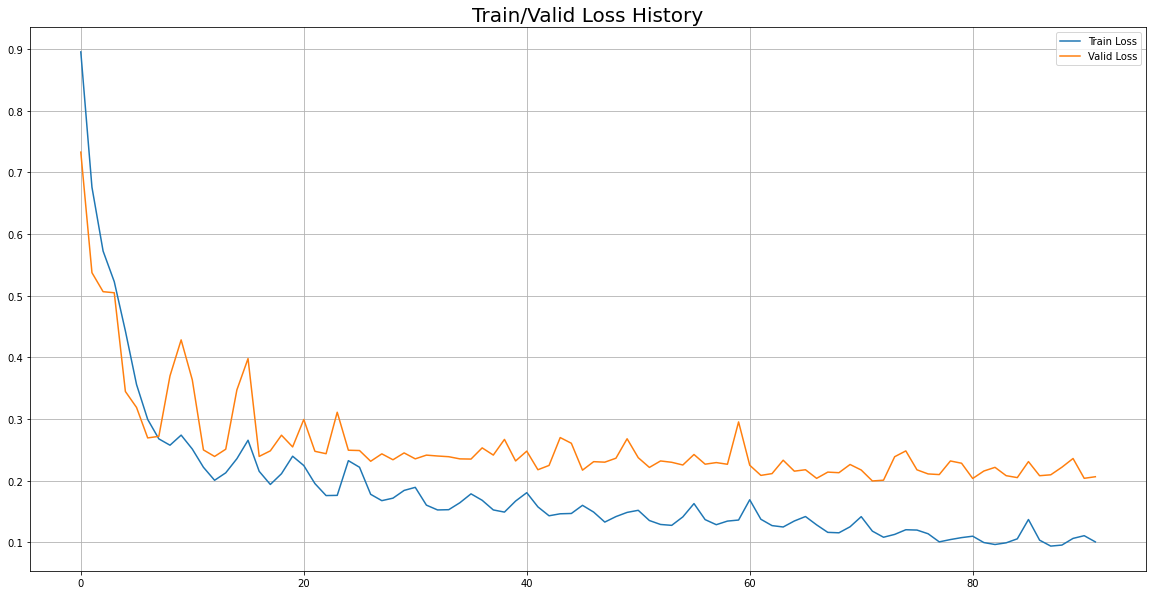

In [40]:
## Train/Valid Loss History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

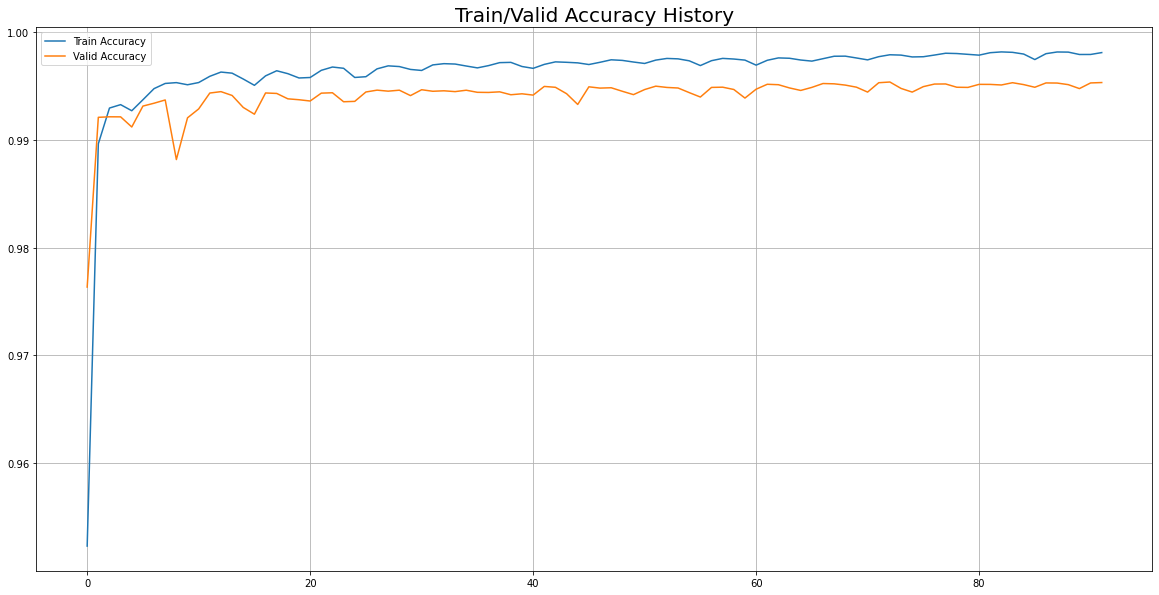

In [41]:
## Train/Valid Accuracy History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Accuracy History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Accuracy'][plot_from:])), 
    result['Train Accuracy'][plot_from:], 
    label = 'Train Accuracy'
    )

plt.plot(
    range(0, len(result['Valid Accuracy'][plot_from:])), 
    result['Valid Accuracy'][plot_from:], 
    label = 'Valid Accuracy'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

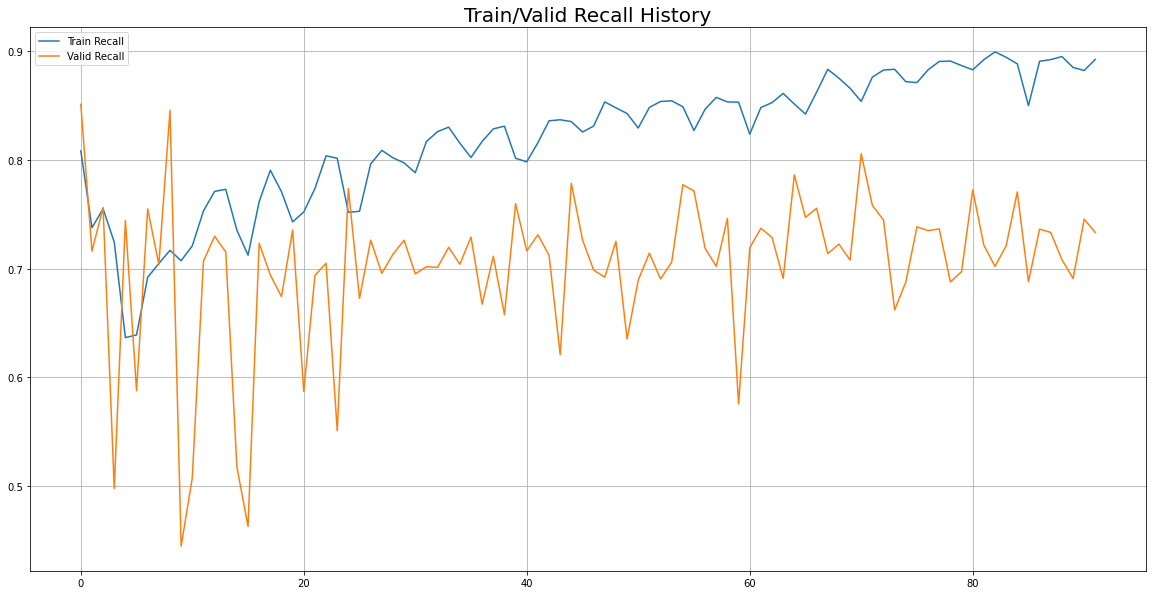

In [42]:
## Train/Valid Recall History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Recall History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Recall'][plot_from:])), 
    result['Train Recall'][plot_from:], 
    label = 'Train Recall'
    )

plt.plot(
    range(0, len(result['Valid Recall'][plot_from:])), 
    result['Valid Recall'][plot_from:], 
    label = 'Valid Recall'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

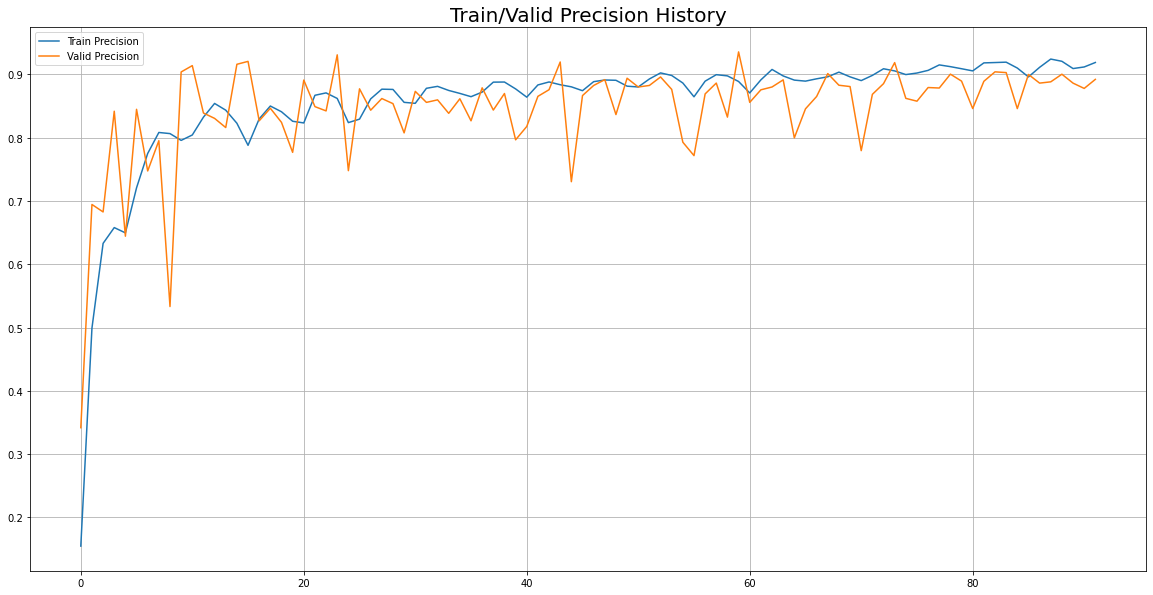

In [43]:
## Train/Valid Precision History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Precision History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Precision'][plot_from:])), 
    result['Train Precision'][plot_from:], 
    label = 'Train Precision'
    )

plt.plot(
    range(0, len(result['Valid Precision'][plot_from:])), 
    result['Valid Precision'][plot_from:], 
    label = 'Valid Precision'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

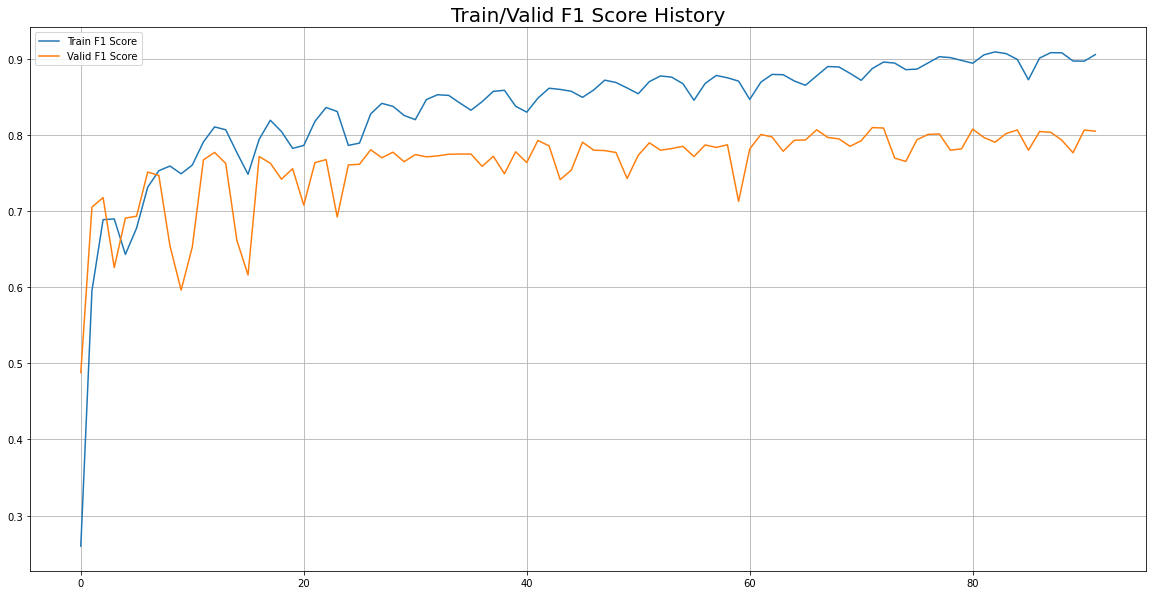

In [44]:
## Train/Valid F1 History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid F1 Score History", fontsize = 20)
plt.plot(
    range(0, len(result['Train F1 Score'][plot_from:])), 
    result['Train F1 Score'][plot_from:], 
    label = 'Train F1 Score'
    )

plt.plot(
    range(0, len(result['Valid F1 Score'][plot_from:])), 
    result['Valid F1 Score'][plot_from:], 
    label = 'Valid F1 Score'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

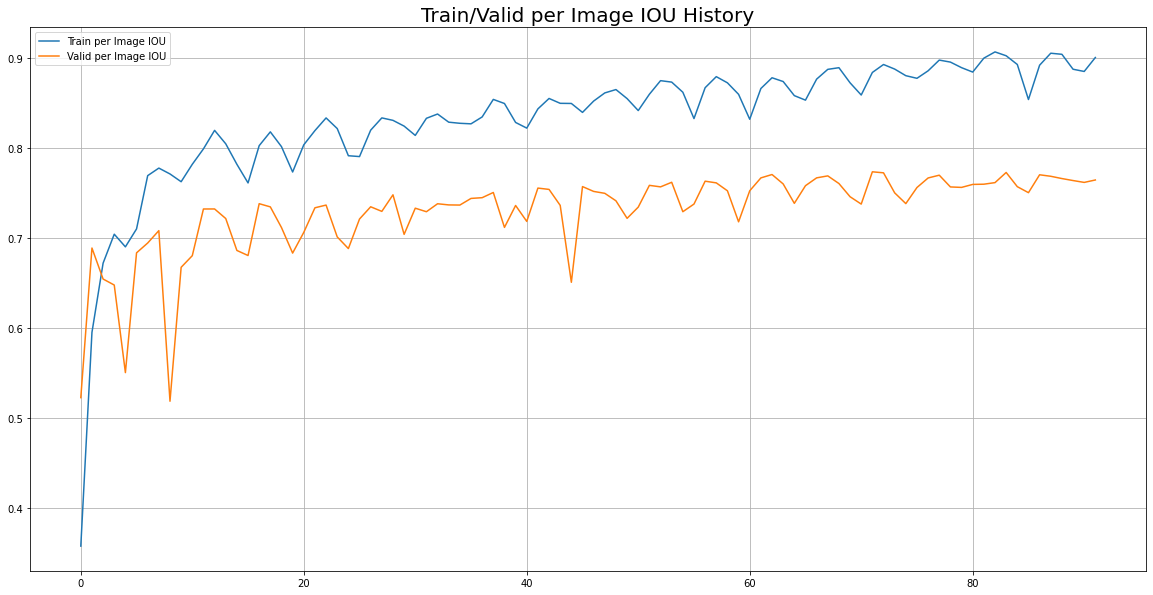

In [45]:
## Train/Valid Per Image IOU History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid per Image IOU History", fontsize = 20)
plt.plot(
    range(0, len(result['Train per Image IOU'][plot_from:])), 
    result['Train per Image IOU'][plot_from:], 
    label = 'Train per Image IOU'
    )

plt.plot(
    range(0, len(result['Valid per Image IOU'][plot_from:])), 
    result['Valid per Image IOU'][plot_from:], 
    label = 'Valid per Image IOU'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

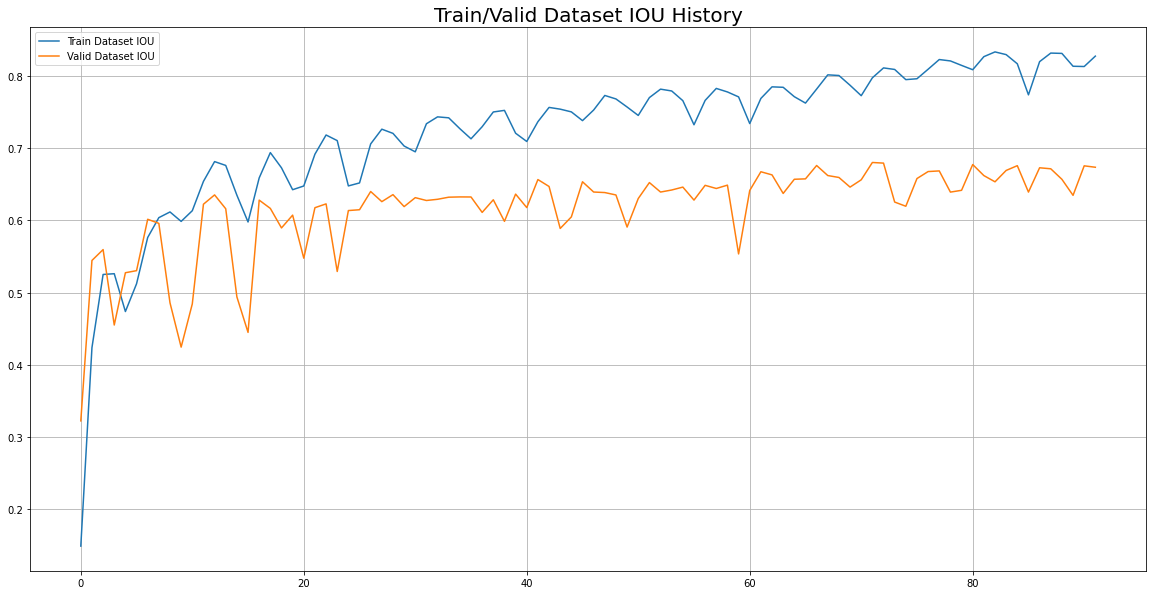

In [46]:
## Train/Valid Dataset IOU History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Dataset IOU History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Dataset IOU'][plot_from:])), 
    result['Train Dataset IOU'][plot_from:], 
    label = 'Train Dataset IOU'
    )

plt.plot(
    range(0, len(result['Valid Dataset IOU'][plot_from:])), 
    result['Valid Dataset IOU'][plot_from:], 
    label = 'Valid Dataset IOU'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Evaluation</span> <a id=6></a>

Evaluation metrics are listed below

# F1Model

In [47]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model_f1.bin'))

<All keys matched successfully>

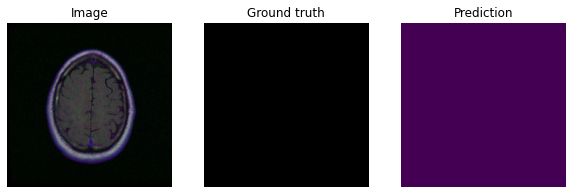

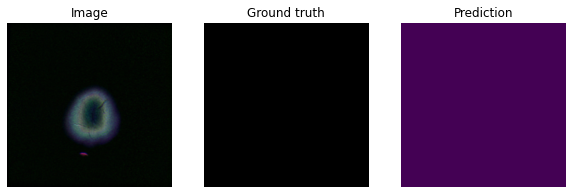

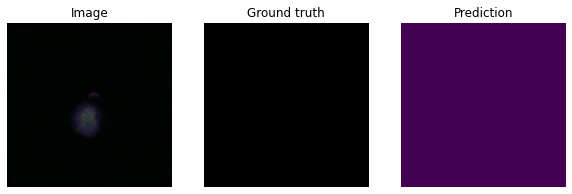

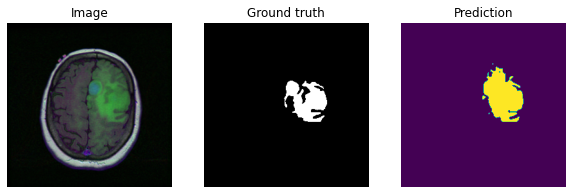

In [58]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

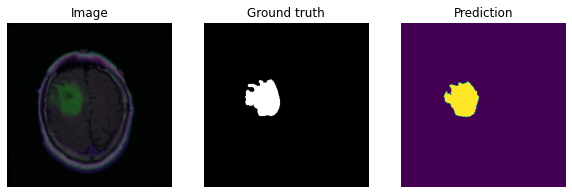

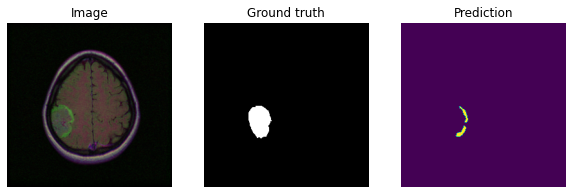

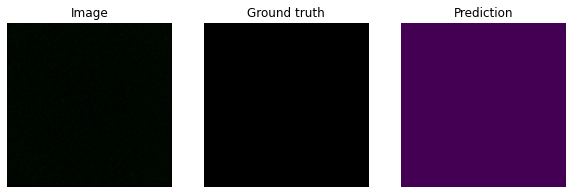

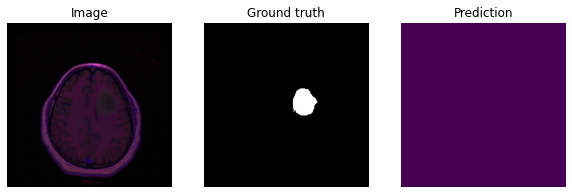

In [53]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

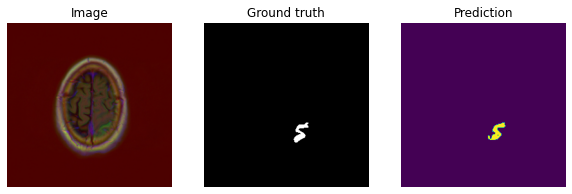

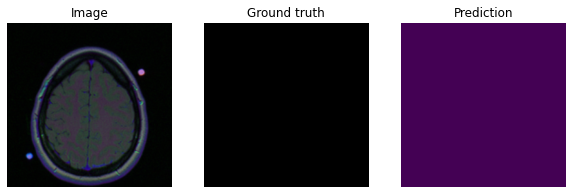

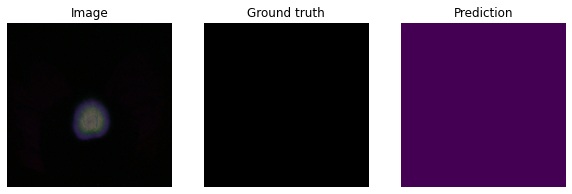

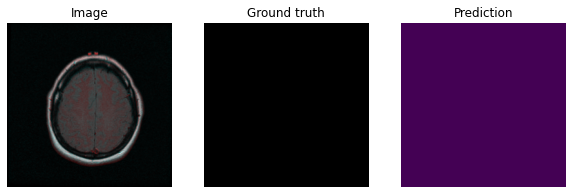

In [59]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

## Better Loss Model

In [60]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model.bin'))

<All keys matched successfully>

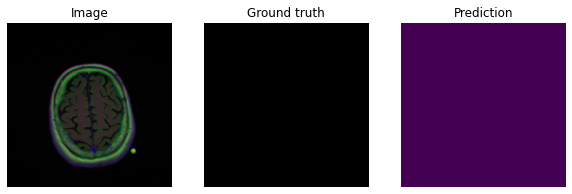

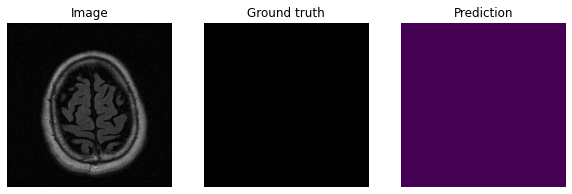

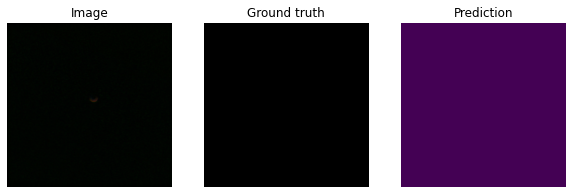

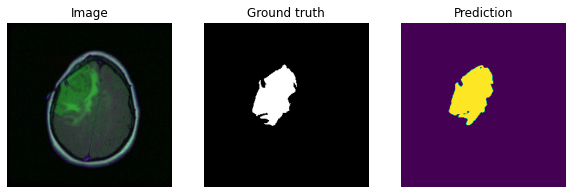

In [61]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

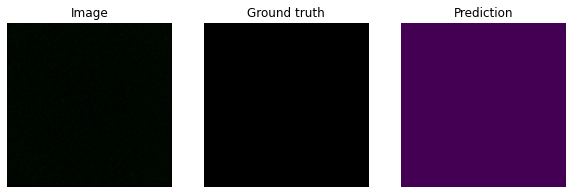

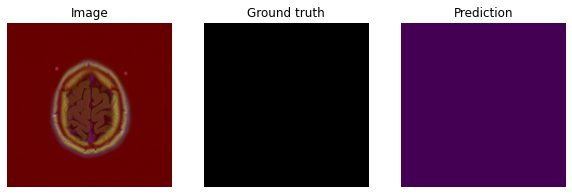

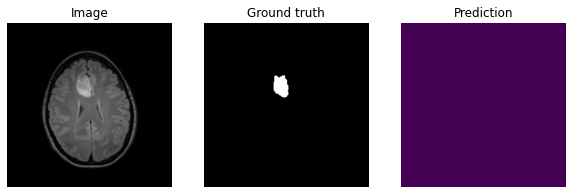

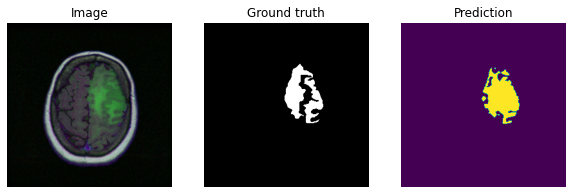

In [62]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

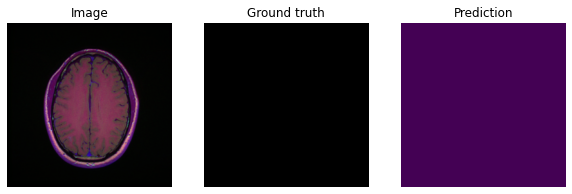

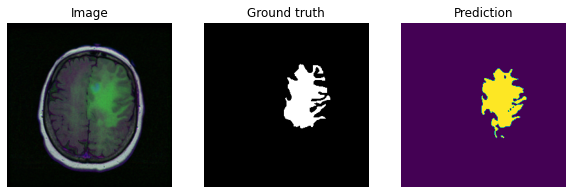

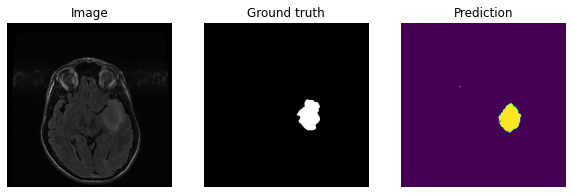

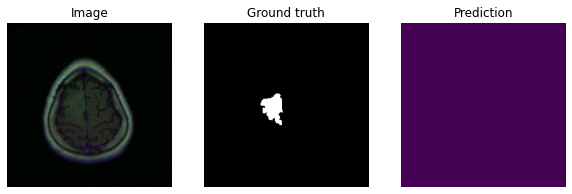

In [63]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()